# Thử nghiệm nhận diện mặt người nổi tiếng Việt Nam

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Check for GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
TEST_PATH = './data/test'
TEST_ALIGNED_PATH = './data/test_aligned'
TRAIN_PATH = './data/train'
TRAIN_ALIGNED_PATH = './data/train_aligned'

BATCH_SIZE = 16
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

VAL_PERCENT = 0.2

In [4]:
random_seed2 = 5

train_set = image_dataset_from_directory(TRAIN_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=VAL_PERCENT, subset='training', seed=random_seed2)
val_set = image_dataset_from_directory(TRAIN_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=VAL_PERCENT, subset='validation', seed=random_seed2)
test_set = image_dataset_from_directory(TEST_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 2957 files belonging to 144 classes.
Using 2366 files for training.
Found 2957 files belonging to 144 classes.
Using 591 files for validation.
Found 643 files belonging to 144 classes.


In [5]:
random_seed = 10

train_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=VAL_PERCENT, subset='training', seed=random_seed)
val_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=VAL_PERCENT, subset='validation', seed=random_seed)
test_aligned_set = image_dataset_from_directory(TEST_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2957 files belonging to 144 classes.
Using 2366 files for training.
Found 2957 files belonging to 144 classes.
Using 591 files for validation.
Found 643 files belonging to 144 classes.


In [6]:
CLASSES = train_set.class_names

NAMES = [line.strip() for line in open('original_labels.txt', 'r', encoding='UTF-8')]

print(len(NAMES))
print(NAMES[:20], '...')
print(CLASSES[:20])

144
['Phạm Nhật Vượng', 'Đoàn Nguyên Đức', 'Đặng Lê Nguyên Vũ', 'Hoài Linh', 'Chí Tài', 'Trường Giang', 'Trấn Thành', 'Nguyễn Thị Ánh Viên', 'Ngô Bảo Châu', 'Đàm Vĩnh Hưng', 'Sơn Tùng M-TP', 'Jack (ca sĩ)', 'Khởi My', 'Đông Nhi', 'Mỹ Tâm', 'Hồ Ngọc Hà', 'Minh Hằng', 'Hari Won', 'Ngọc Trinh', 'Tăng Thanh Hà'] ...
['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115']


In [16]:
import json
labels_map = {c : NAMES[int(c)] for c in CLASSES}
json.dump(labels_map, open('labels_map.json', 'w', encoding='UTF-8'), ensure_ascii=False)

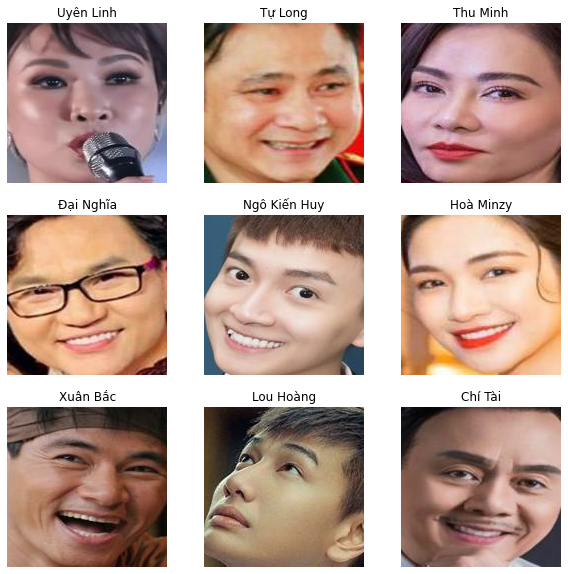

In [7]:
# Show the first 8 images (1 batch) and labels in the training set
plt.figure(figsize = (10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(NAMES[int(CLASSES[labels[i]])])
        plt.axis('off')

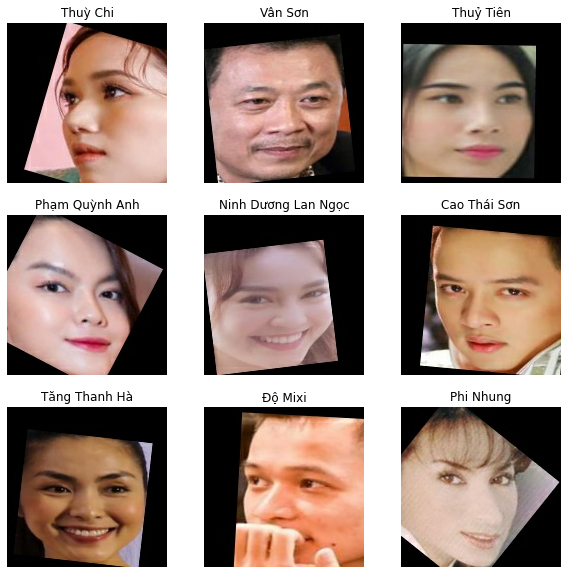

In [8]:
# Try again with aligned train images
plt.figure(figsize = (10, 10))
for images, labels in train_aligned_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(NAMES[int(CLASSES[labels[i]])])
        plt.axis('off')

In [7]:
# To improve image loading performance
AUTOTUNE = tf.data.experimental.AUTOTUNE # for tf 2.3-; for tf 2.4+ remove 'experimental'

train_aligned_set = train_aligned_set.prefetch(buffer_size = AUTOTUNE)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)

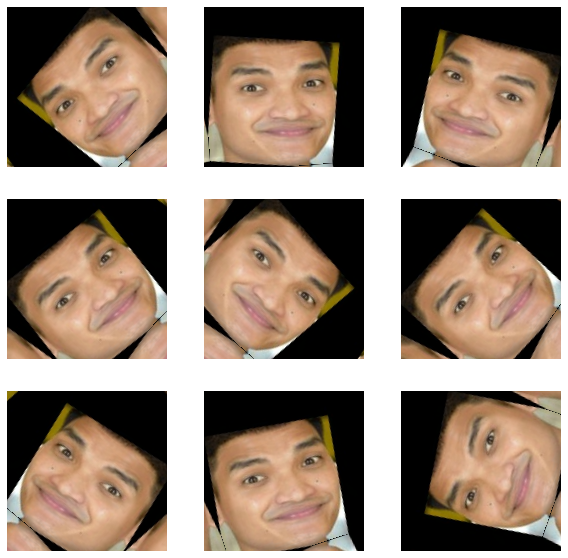

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'), 
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
# more augmentation recommended if resource allows

# Test with an image to see the augmentations
for images, _ in train_aligned_set.take(1):
    plt.figure(figsize = (10, 10))
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
MODEL_PATH = './models/'

In [9]:
base_model = tf.keras.models.load_model(MODEL_PATH + 'facenet_keras.h5')

In [10]:
print(len(base_model.layers))
print(base_model.inputs)
print(base_model.outputs)

426
[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [12]:
base_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [13]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 128)


In [14]:
#base_model.trainable = False # currently just do transfer learning

# for further fine-tuning
#for layer in base_model.layers[:438]: # Freeze all layers before this point
    #layer.trainable = False

# TRANSFER LEARNING DO NOT WORK
# WE WILL DO FULL TRAINING INSTEAD
base_model.trainable = True

# Add 2 dense layers
dense_layer = tf.keras.layers.Dense(256, activation='relu') # if resource allows, try bigger number of neurals
output_layer = tf.keras.layers.Dense(len(CLASSES), activation='softmax') # 144 classes, use softmax for multi class
# Actually, we will try with 1 dense layer (output) only

# Compile the model
inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
x = base_model(inputs)

DROPOUT_RATE = 0.2
#x = dense_layer(x) # if one dense work well then avoid complication
#x = tf.keras.layers.Dropout(DROPOUT_RATE)(x) # dropout not work well -> currently not using it
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
dense_1 (Dense)              (None, 144)               18576     
Total params: 22,826,720
Trainable params: 22,797,888
Non-trainable params: 28,832
_________________________________________________________________


In [15]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optim, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [16]:
# initial loss & accuracy
loss0, accuracy0 = model.evaluate(val_aligned_set)

37/37 [==============================] - 19s 501ms/step - loss: 7.0292 - accuracy: 0.0034


In [17]:
history = model.fit(train_aligned_set, epochs=20, validation_data=val_aligned_set) # try more epochs if time allows

Epoch 1/20
148/148 [==============================] - 67s 456ms/step - loss: 4.3024 - accuracy: 0.1441 - val_loss: 3.7577 - val_accuracy: 0.2640
Epoch 2/20
148/148 [==============================] - 51s 342ms/step - loss: 2.2335 - accuracy: 0.7164 - val_loss: 2.8154 - val_accuracy: 0.5719
Epoch 3/20
148/148 [==============================] - 51s 341ms/step - loss: 1.1243 - accuracy: 0.9505 - val_loss: 2.2108 - val_accuracy: 0.7157
Epoch 4/20
148/148 [==============================] - 51s 342ms/step - loss: 0.5743 - accuracy: 0.9911 - val_loss: 1.7800 - val_accuracy: 0.7750
Epoch 5/20
148/148 [==============================] - 51s 345ms/step - loss: 0.3230 - accuracy: 0.9941 - val_loss: 1.4902 - val_accuracy: 0.8173
Epoch 6/20
148/148 [==============================] - 51s 343ms/step - loss: 0.2185 - accuracy: 0.9954 - val_loss: 1.3258 - val_accuracy: 0.8206
Epoch 7/20
148/148 [==============================] - 51s 344ms/step - loss: 0.1614 - accuracy: 0.9949 - val_loss: 1.2662 - val_ac

In [11]:
model.save(MODEL_PATH + 'facenet_trained.h5')

In [18]:
model.evaluate(test_aligned_set)

41/41 [==============================] - 11s 261ms/step - loss: 0.9631 - accuracy: 0.8305


[0.9631368517875671, 0.8304821252822876]

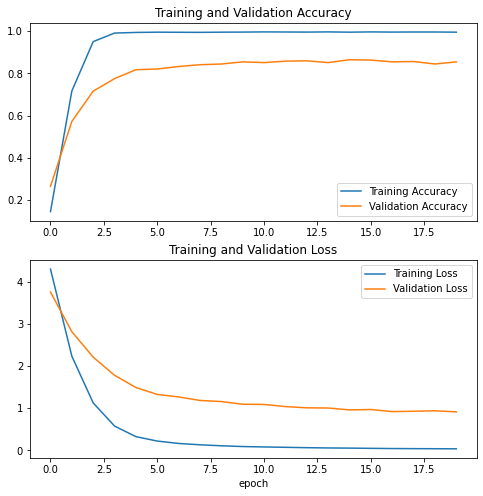

In [19]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

## Phần thử nghiệm với embedding vectors
* Làm việc với vector rất nhiều chiều (128-512 chiều), không khả thi để train (do máy hơi cùi), 1 epoch chạy rất lâu

In [ ]:
emb_gen = FaceNet()

In [ ]:
def prepare_emb(dataset):
    return dataset.map(lambda img, lbl: (emb_gen.model(img), lbl))

In [ ]:
emb_train_set = prepare_emb(train_set)
emb_test_set = prepare_emb(test_set)
emb_val_set = prepare_emb(val_set)

In [ ]:
emb_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(512, input_dim=512, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax'),
    ]
)
emb_model.summary()

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.01)

emb_model.compile(optimizer=optim, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
emb_hist = emb_model.fit(emb_train_set, epochs=50, validation_data=emb_val_set)